## Import All Libraries

In [45]:
# Read data and EDA
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

# Preparation and Evaluation
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Model Implementation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, SimpleRNN, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

import gc

## Load Data

In [46]:
train_data = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
train_data = train_data.rename(columns={'label': 'generated', 'prompt_name': 'prompt_id'}, errors='ignore')
train_data

,text,generated,prompt_id,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [47]:
test_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [48]:
sample_sub = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


## Exploratory Data Analysis (EDA)

In [49]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_id      44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


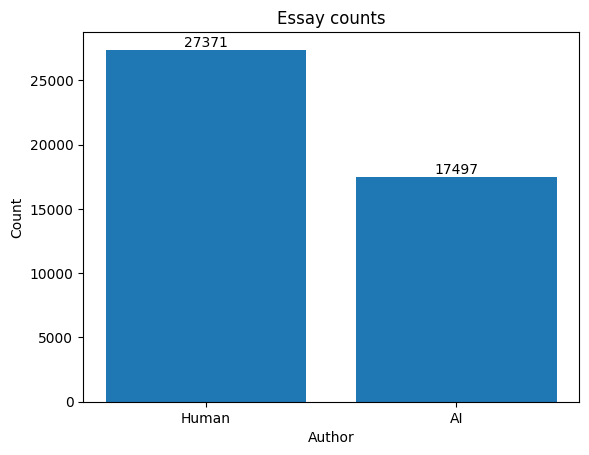

In [50]:
human_ai_count = train_data['generated'].value_counts().reset_index()
human_ai_count['generated'] = human_ai_count['generated'].replace({0: 'Human', 1: 'AI'})
plt.bar(human_ai_count['generated'], human_ai_count['count'])
plt.xlabel('Author')
plt.ylabel('Count')
plt.title('Essay counts')
[plt.text(lbl, count, count, ha="center", va="bottom") for (lbl, count) in human_ai_count.to_numpy()]
plt.show()

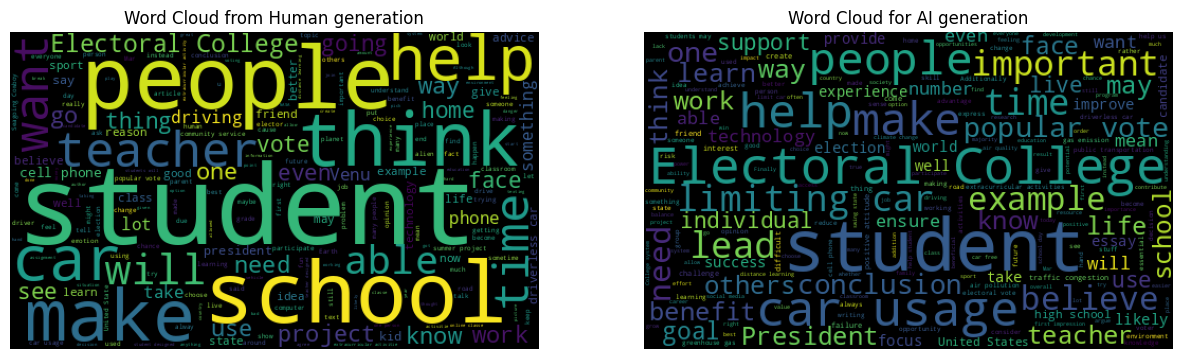

In [51]:
# Convert all articles into single string
word_cloud_0 = train_data.query('generated == 0')['text'].str.cat(sep=" ")
word_cloud_0 = WordCloud(width=500, height=300).generate(word_cloud_0)
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(word_cloud_0)
plt.title('Word Cloud from Human generation')
plt.axis("off")

plt.subplot(1, 2, 2)
word_cloud_1 = train_data.query('generated == 1')['text'].str.cat(sep=" ")
word_cloud_1 = WordCloud(width=500, height=300).generate(word_cloud_1)
plt.imshow(word_cloud_1)
plt.title('Word Cloud for AI generation')
plt.axis("off")

plt.show()

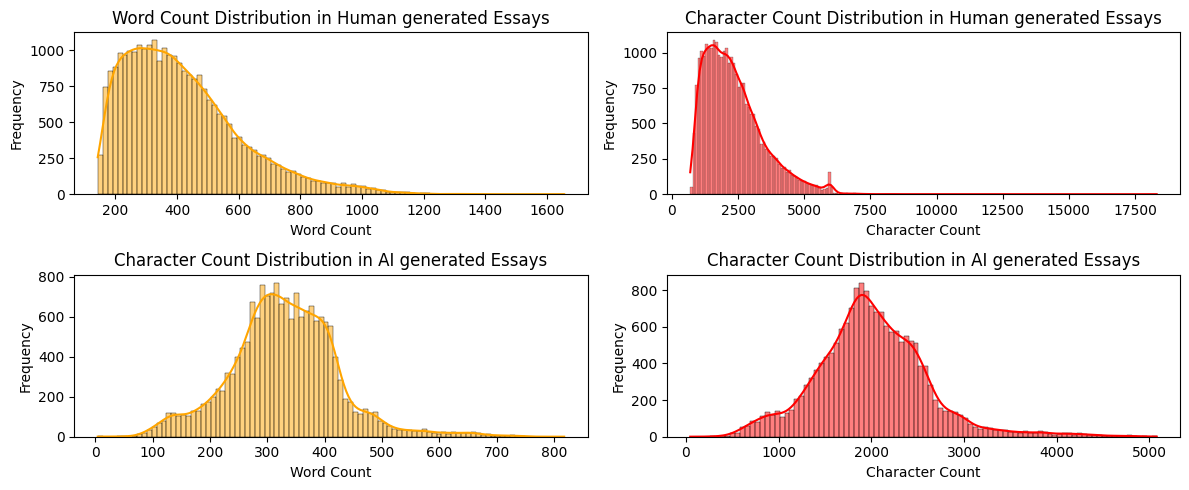

In [52]:
def show_hist_plot(series, title, xlabel, ylabel, color):
    sns.histplot(series, kde=True, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
train_data['char_count'] = train_data['text'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
show_hist_plot(train_data.query('generated == 0')['word_count'], 'Word Count Distribution in Human generated Essays', 'Word Count', 'Frequency', 'orange')

plt.subplot(2, 2, 2)
show_hist_plot(train_data.query('generated == 0')['char_count'], 'Character Count Distribution in Human generated Essays', 'Character Count', 'Frequency', 'red')

plt.subplot(2, 2, 3)
show_hist_plot(train_data.query('generated == 1')['word_count'], 'Character Count Distribution in AI generated Essays', 'Word Count', 'Frequency', 'orange')

plt.subplot(2, 2, 4)
show_hist_plot(train_data.query('generated == 1')['char_count'], 'Character Count Distribution in AI generated Essays', 'Character Count', 'Frequency', 'red')

plt.tight_layout()
plt.show()

## Data Pre-processing

In [53]:
max_len = 1000

vectorize_layer = TextVectorization(output_sequence_length=max_len)
vectorize_layer.adapt(train_data['text'])

In [54]:
train_vectorized_text = vectorize_layer(train_data['text']).numpy()
train_vectorized_text[:10]

array([[ 126, 1243,  420, ...,    0,    0,    0],
       [  22,  414,   33, ...,    0,    0,    0],
       [  99,   80,    2, ...,    0,    0,    0],
       ...,
       [ 126,    4,   99, ...,    0,    0,    0],
       [  26,   16, 5527, ...,    0,    0,    0],
       [ 444,    4,   99, ...,    0,    0,    0]])

In [55]:
train_vectorized_text.shape

(44868, 1000)

## Data Split for train and test purpose for base model

In [56]:
x_train, x_val, y_train, y_val = train_test_split(train_vectorized_text, train_data['generated'], test_size=0.2, shuffle=True)

In [57]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(35894, 1000)
(8974, 1000)
(35894,)
(8974,)


In [ ]:
plt.pie([x_train.shape[0], x_val.shape[0]], labels=['Train', 'Val'])
plt.title('Train and Validation counts')
plt.show()

In [58]:
y_train_np = y_train.values
y_val_np = y_val.values

## RNN

In [114]:
def rnn_model():
    rnn = Sequential()
    
    rnn.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=256, input_length=max_len))
    rnn.add(Bidirectional(SimpleRNN(100)))
    rnn.add(Dense(100, activation='relu'))
    rnn.add(Dropout(0.1))
    rnn.add(Dense(units=1, activation='sigmoid'))
    return rnn

model = rnn_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 256)         27272704  
                                                                 
 bidirectional_5 (Bidirecti  (None, 200)               71400     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 27364305 (104.39 MB)
Trainable params: 27364305 (104.39 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [115]:
EPOCHS = 3
BATCH_SIZE = 64
history = model.fit(x_train, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val_np))

Epoch 1/3
561/561 [==============================] - 898s 2s/step - loss: 0.2827 - accuracy: 0.8868 - val_loss: 0.3920 - val_accuracy: 0.8393
Epoch 2/3
561/561 [==============================] - 866s 2s/step - loss: 0.1397 - accuracy: 0.9518 - val_loss: 0.2346 - val_accuracy: 0.9082
Epoch 3/3
561/561 [==============================] - 862s 2s/step - loss: 0.1088 - accuracy: 0.9651 - val_loss: 0.0898 - val_accuracy: 0.9713


In [116]:
loss, acc = model.evaluate(x_val, y_val_np)

281/281 [==============================] - 32s 114ms/step - loss: 0.0898 - accuracy: 0.9713


In [117]:
print("Loss on validation data is:", loss)
print("Accuracy on validation data:", acc)

Loss on validation data is: 0.08981994539499283
Accuracy on validation data: 0.9712502956390381


In [118]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

281/281 [==============================] - 32s 113ms/step


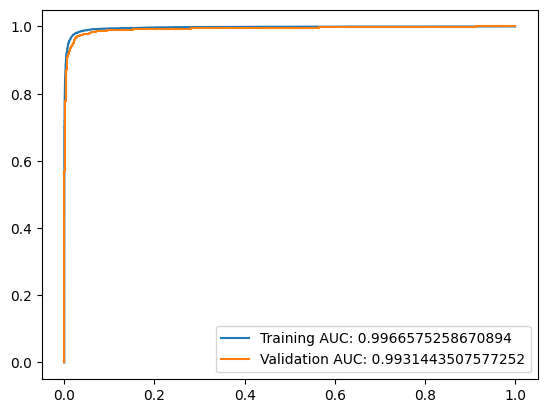

In [119]:
fpr_train, tpr_train, _ = roc_curve(y_train_np, y_train_pred)
auc_train = roc_auc_score(y_train_np, y_train_pred)
plt.plot(fpr_train, tpr_train ,label=f"Training AUC: {auc_train}")

fpr_val, tpr_val, _ = roc_curve(y_val_np, y_val_pred)
auc_val = roc_auc_score(y_val_np, y_val_pred)
plt.plot(fpr_val, tpr_val, label=f"Validation AUC: {auc_val}")

plt.legend()
plt.show()

## Test Data Preprocessing and Prediction

In [120]:
test_vectorized_text = vectorize_layer(test_essay['text']).numpy()
test_vectorized_text.shape

(3, 1000)

In [121]:
y_pred = model.predict(test_vectorized_text)
y_pred

1/1 [==============================] - 0s 125ms/step


array([[0.9705166 ],
       [0.96053284],
       [0.96053284]], dtype=float32)

In [122]:
final_submission = pd.DataFrame({'id': test_essay['id'], 'generated': [y[0] for y in y_pred]})
final_submission.to_csv('submission.csv', index=False)

In [123]:
# ChatGPT 3.5 Generated paragraphs on prompt ID 0
gpt_text = 'In our rapidly evolving world, the convenience of personal automobiles has become deeply ingrained in our daily lives. However, it is essential to consider the broader implications of our reliance on cars, not just for individual comfort but also for the collective well-being of our society and the environment. This essay explores the advantages of limiting car usage, drawing insights from multiple sources to underscore the importance of embracing alternative transportation methods for a sustainable future.'
gpt_text_2 = 'One significant advantage of reducing car usage lies in the realm of environmental preservation. According to a report by the Environmental Protection Agency (EPA), the transportation sector is a major contributor to air pollution and greenhouse gas emissions. Cars emit pollutants that degrade air quality, leading to respiratory problems and other health issues. By limiting car usage and promoting alternatives such as public transportation, cycling, and walking, we can collectively reduce our carbon footprint and mitigate the impact of climate change.'
gpt_text_3 = 'Furthermore, limiting car usage can have profound positive effects on traffic congestion and urban planning. A study conducted by the Urban Land Institute reveals that the overreliance on cars contributes to congested roadways, leading to increased travel times and economic inefficiencies. Implementing measures to limit car usage, such as developing comprehensive public transportation systems and promoting carpooling, can alleviate traffic congestion, making cities more livable and efficient.'

# BBC news articles
bbc_text = 'Those alleged conversations were outlined in an indictment unsealed by US prosecutors on Wednesday. The US Justice Department has charged Mr Gupta with an elaborate plot to assassinate a dual US-Canadian citizen based in New York, a plot allegedly directed by an Indian government employee.'
bbc_text_1 = 'In the Paris Agreement itself, the baseline for pre-industrial measures wasn\'t defined. But the International Panel on Climate Change uses a baseline of 1850-1900. That\'s because it\'s the earliest period with reliable, near-global measurements. It\'s true that some warming from human activity had already occurred by that point, because the industrial revolution began in the early 1700s. But having good historical data for a reliable baseline is crucial to measure changes happening today.'
bbc_text_2 = 'The room bustled with the din of volunteer waitstaff and diners amid a jazzy soundtrack playing overhead. A knife suddenly clanged against the floor. No one seemed to hear it except for renowned, three-Michelin starred chef Massimo Bottura, who instinctively ran over to pick it up, gave the diner a new utensil and initiated a warm, friendly chat to ensure he was enjoying his meal. With Bottura, the patrons at this church hall are given the same level of hospitality as those at his high-end restaurants like the famed Osteria Francescana and the newly opened Al Gatto Verde in Modena, Italy.'

extra_texts = [gpt_text, gpt_text_2, gpt_text_3, bbc_text, bbc_text_1, bbc_text_2]
extra_texts = pd.DataFrame({'text': extra_texts, 'generated': [1, 1, 1, 0, 0, 0]})
extra_vectorized_text = vectorize_layer(extra_texts['text']).numpy()
model.evaluate(extra_vectorized_text, extra_texts['generated'])

1/1 [==============================] - 1s 580ms/step - loss: 0.6827 - accuracy: 0.5000


[0.6826950907707214, 0.5]

In [124]:
# model.save_weights('detect_ai_generated')

In [125]:
# model = rnn_model()
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# model.load_weights('detect_ai_generated')

In [126]:
# model.evaluate(extra_text_padded, extra_texts['generated'].values)

1/1 [==============================] - 0s 128ms/step


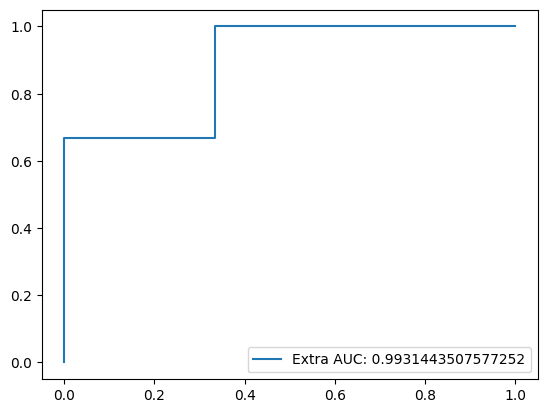

In [127]:
y_extra_pred = model.predict(extra_vectorized_text)

fpr_extra, tpr_extra, _ = roc_curve(extra_texts['generated'].values, y_extra_pred)
auc_extra = roc_auc_score(extra_texts['generated'].values, y_extra_pred)
plt.plot(fpr_extra, tpr_extra, label=f"Extra AUC: {auc_val}")
plt.legend()
plt.show()

In [128]:
daigt = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv")
daigt

,id,text,instructions,source_text
0,6060D28C05B6,Some schools in United States ofter classes fr...,\nTask: Write a persuasive essay on whether or...,\nWhen considering the pros and cons of attend...
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",\nTask: Research the advantages and disadvanta...,\nOne of the primary arguments for implementin...
2,607A39D981DE,Students and their families should consider an...,\nTask: \n\n1. Talk to your parents before tak...,\nBefore making any decisions about getting in...
3,60ACDFA1609E,Agree you will never grow if something beyond ...,\nTask: Write an essay discussing the benefits...,"\nRalph Waldo Emerson once said, ""Go confident..."
4,60AE13D3F07B,I think our character traits are formed by inf...,\nTask: Research and discuss how character tra...,\nHuman character traits are shaped by a wide ...
...,...,...,...,...
2416,F5FF5E9E553C,"On september 2, 2015 Generic_Name was entering...",\nTask: Research different kinds of medical pr...,\nBecoming a surgeon requires a great deal of ...
2417,F60545D8271E,I think that schools must have a after school ...,\nTask: Write an essay discussing why schools ...,\nSchools should offer an after school homewor...
2418,F610B3CBF3DF,"Winston Churchill once said ""success consists ...",\nTask: Write an essay about how having a few ...,\nIt’s human nature to be afraid to make mista...
2419,F610C7BCD9EC,Technology seems to be becoming more and more ...,\nTask: \n\nWrite an essay exploring the pros ...,\nOne of the main debates of 2020 for many stu...


In [129]:
daigt_human = pd.DataFrame({'text': daigt['text'], 'generated': 0})
daigt_ai = pd.DataFrame({'text': daigt['source_text'], 'generated': 1})
daigt_data = pd.concat([daigt_human, daigt_ai], ignore_index=True)
daigt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4842 entries, 0 to 4841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4842 non-null   object
 1   generated  4842 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [130]:
daigt_vectorized_text = vectorize_layer(daigt_data['text']).numpy()
model.evaluate(daigt_vectorized_text, daigt_data['generated'].values)

152/152 [==============================] - 17s 113ms/step - loss: 0.6478 - accuracy: 0.7755


[0.6478098630905151, 0.7755059599876404]

152/152 [==============================] - 17s 112ms/step


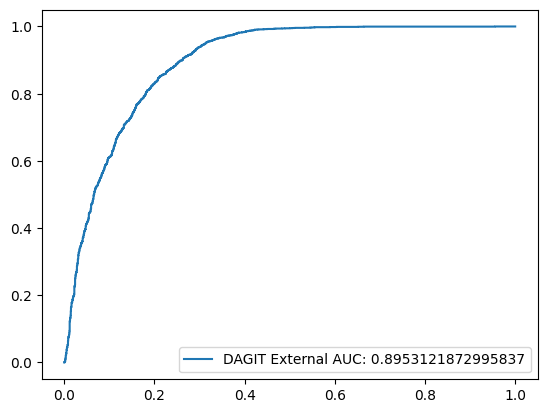

In [131]:
y_daigt_pred = model.predict(daigt_vectorized_text)

fpr_daigt, tpr_daigt, _ = roc_curve(daigt_data['generated'].values, y_daigt_pred)
auc_daigt = roc_auc_score(daigt_data['generated'].values, y_daigt_pred)
plt.plot(fpr_daigt, tpr_daigt, label=f"DAGIT External AUC: {auc_daigt}")
plt.legend()
plt.show()